### Entranamiento / Evaluación

In [113]:
%pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.


#### 💪 Training

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [115]:
proc_data_path='../data/processed/road_traffic_accidents_dataset_proc.csv'
train_data = pd.read_csv(proc_data_path)


In [116]:
x = train_data.drop('accident_severity', axis=1)
y = train_data['accident_severity']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)


In [117]:
print('Train x shape:', xtrain.shape)
print('Train y shape:', ytrain.shape)
print('Test x shape:', xtest.shape)
print('Test y shape:', ytest.shape)

xtrain.to_csv('../data/train/xtrain.csv', index=False)
ytrain.to_csv('../data/train/ytrain.csv', index=False)
xtest.to_csv('../data/test/xtest.csv', index=False)
ytest.to_csv('../data/test/ytest.csv', index=False)


Train x shape: (9852, 229)
Train y shape: (9852,)
Test x shape: (2464, 229)
Test y shape: (2464,)


In [118]:
models={"LogisticRegression":LogisticRegression(max_iter=1000),
        "DecisionTreeClassifier":DecisionTreeClassifier(random_state=42),
        "KNeighborsClassifier":KNeighborsClassifier(n_neighbors=5),
        # "SVC":SVC(kernel="linear", C=0.0001),
        "RandomForestClassifier":RandomForestClassifier(n_estimators=200, random_state=42),
        # "AdaBoostClassifier":AdaBoostClassifier(n_estimators=200, random_state=42),
        # "GradientBoostingClassifier":GradientBoostingClassifier(n_estimators=200, random_state=42),
        }


In [119]:
def modelAccuracy(models,x,y):
    #train/Test
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
    acc_result={}
    for name,model in models.items():
        #pipeline
        #1.Transformer -> 2.Model
        model_pipeline=Pipeline([('StandardScaler',StandardScaler()),('model',model)])

        #training/testing on model pipeline
        model_fit=model_pipeline.fit(xtrain,ytrain)
        ypred=model_fit.predict(xtest)
        acc=accuracy_score(ytest,ypred)
        print("The Accuracy for {:<25} is: {:>16.13f}".format(name, acc))
        acc_result[name]=acc
    return acc_result

In [120]:
acc_result=modelAccuracy(models,x,y)

The Accuracy for LogisticRegression        is:  0.8368506493506
The Accuracy for DecisionTreeClassifier    is:  0.7751623376623
The Accuracy for KNeighborsClassifier      is:  0.8364448051948
The Accuracy for RandomForestClassifier    is:  0.8429383116883


In [121]:
def bestModel(result):
    high=0
    for name,acc in result.items():
        if acc>high:
            high=acc
            model_name=name
    print("Best Model is ",model_name," with accuaracy =>",high)

In [122]:
bestModel(acc_result)

Best Model is  RandomForestClassifier  with accuaracy => 0.8429383116883117


In [123]:
def bestParams(model,param,xtrain,ytrain):
    cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    grid_cv=GridSearchCV(estimator=model,param_grid=param,cv=cv,scoring="accuracy",n_jobs=-1,verbose=1)
    res=grid_cv.fit(xtrain,ytrain)
    print("Best Parameters are ",res.best_params_)
    print("Best Accuracy is ",res.best_score_)


In [124]:
model=RandomForestClassifier()
params={"n_estimators" : [50,100,200],
        "max_leaf_nodes" : [5,10,20],
        }
bestParams(model,params,xtrain,ytrain)

Fitting 15 folds for each of 9 candidates, totalling 135 fits
Best Parameters are  {'max_leaf_nodes': 5, 'n_estimators': 50}
Best Accuracy is  0.8476451696811894


In [125]:
#retrain the model with best parameters
model=RandomForestClassifier(n_estimators=50, max_leaf_nodes=5, class_weight='balanced')
model.fit(xtrain,ytrain)
ypred=model.predict(xtest)
print("Accuracy of the model is ",accuracy_score(ytest,ypred))


Accuracy of the model is  0.5957792207792207


In [126]:
import pickle
pickle.dump(model,open("../models/road_traffic_accidents_model.pkl","wb"))


Accuracy: 0.5957792207792207

Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.51      0.11        37
           1       0.20      0.34      0.25       363
           2       0.87      0.64      0.74      2064

    accuracy                           0.60      2464
   macro avg       0.38      0.50      0.37      2464
weighted avg       0.76      0.60      0.66      2464


Confusion Matrix:
[[  19   10    8]
 [  44  124  195]
 [ 257  482 1325]]


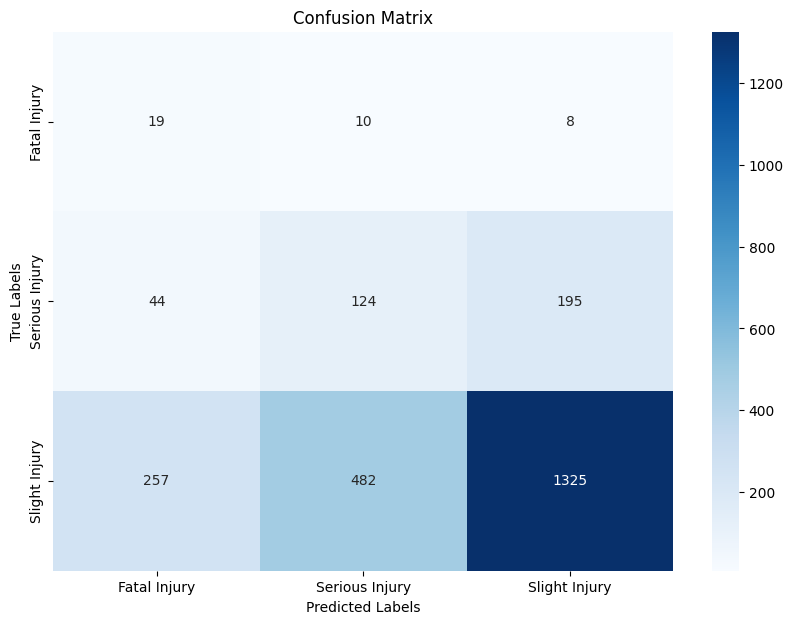

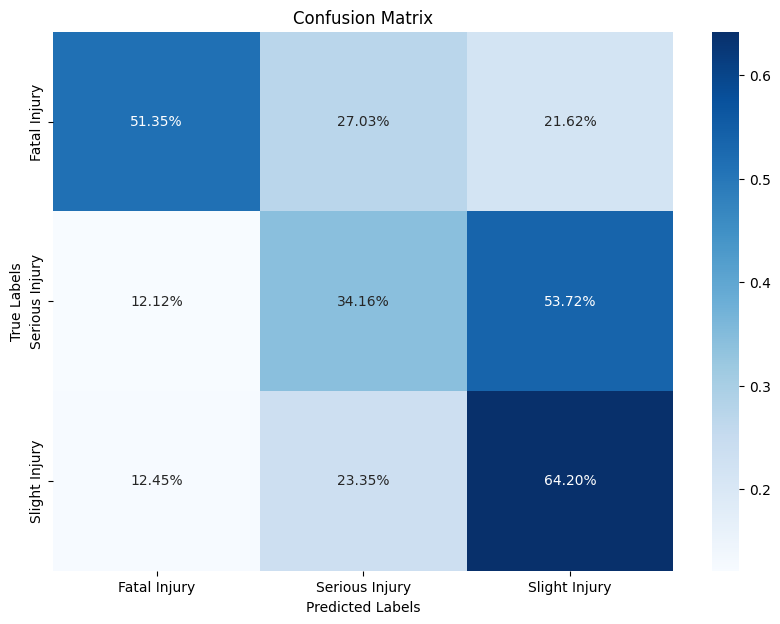

In [127]:
print("Accuracy:", accuracy_score(ytest, ypred))

print("\nClassification Report:")
print(classification_report(ytest, ypred, zero_division=0))

c_matrix = confusion_matrix(ytest, ypred)
print("\nConfusion Matrix:")
print(c_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'], yticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(ytest, ypred, normalize='true'), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'], yticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Feature Importances:
                                    feature  importance
159                  number_of_casualties_4    0.128538
35               age_band_of_driver_unknown    0.062021
156                  number_of_casualties_1    0.057632
150           number_of_vehicles_involved_1    0.056533
129  light_conditions_darkness - lights lit    0.055194
151           number_of_vehicles_involved_2    0.048267
21                                  time_21    0.044114
24                       day_of_week_friday    0.040760
113              types_of_junction_crossing    0.040218
26                     day_of_week_saturday    0.019570


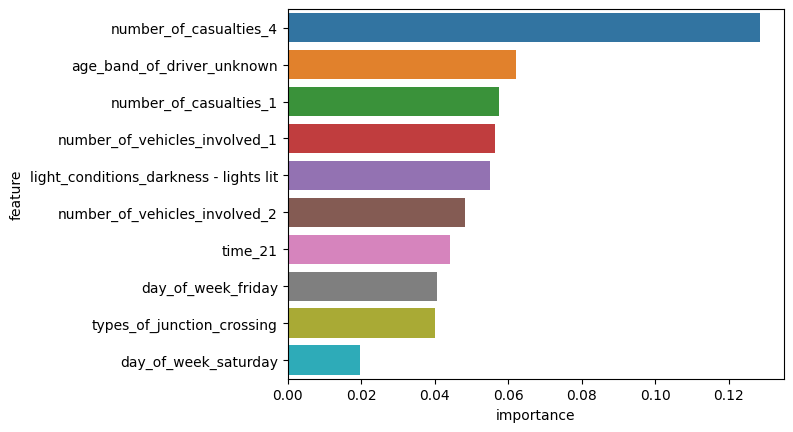

In [128]:
# Print the feature importances
feature_importances = model.feature_importances_
feature_names = x.columns
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances_df.head(10))

sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10), hue='feature');
